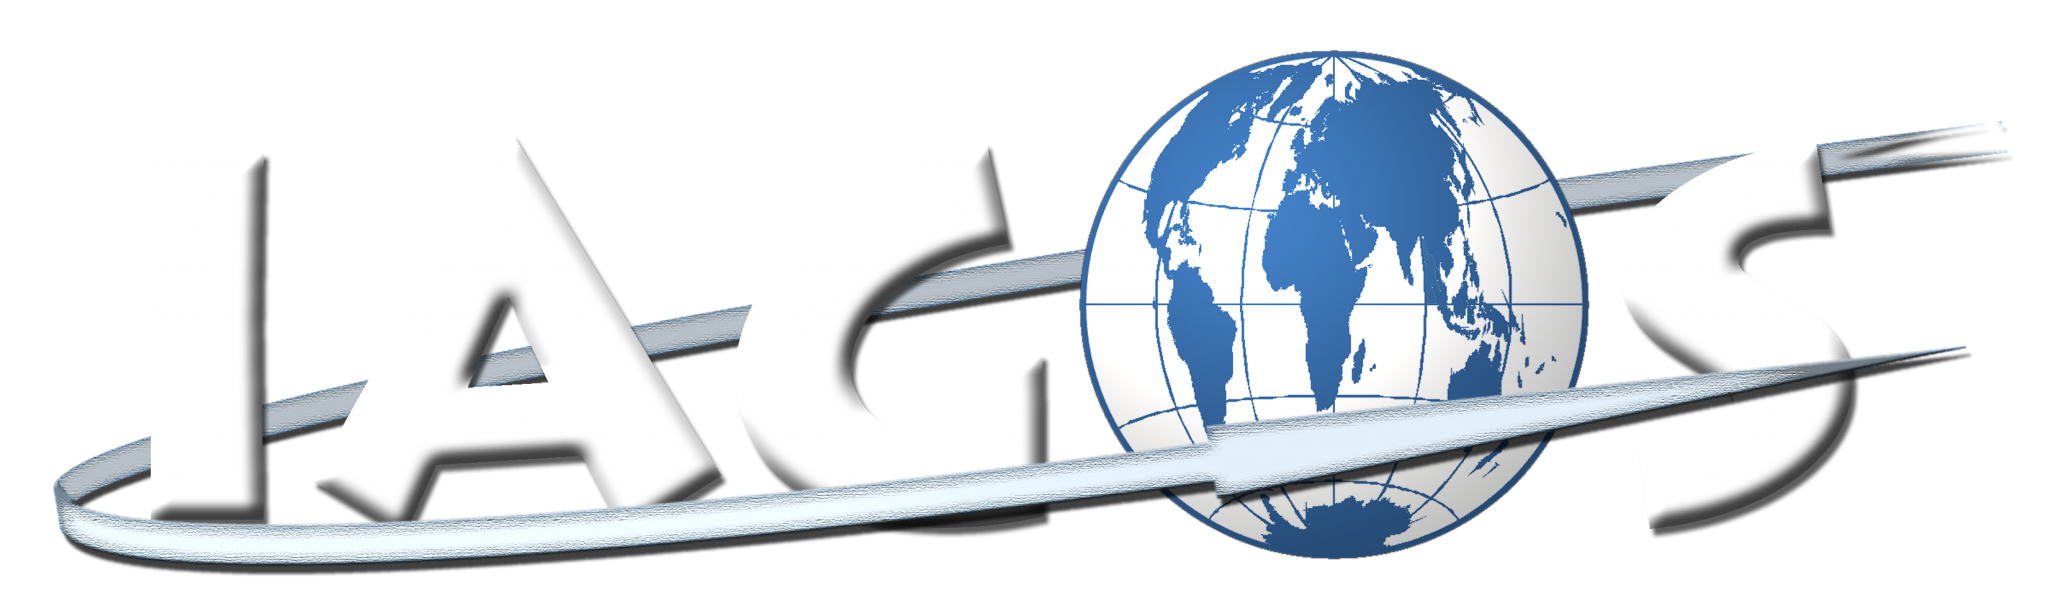


# Plotting IAGOS data

This Jupyter Notebook a demonstration on how to plot data from the IAGOS project in python.

## Source Data

The source data for any plots in this notebook are the from [IAGOS](https://www.iagos.org/) research data which are gained by installing packages on passenger flights and are publicly available and licensed under the [Creative Commons Attribution 4.0 International licence (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/).

The Source data is provided as NetCDF files that among others usually have the following variables to analyse:

Base data:
- UTC_time
- lon
- lat

Data with validity flags (data_name_validity_flag)
- baro_alt_AC
- radio_alt_AC
- air_press_AC
- air_temp_AC
- air_speed_AC
- ground_speed_AC
- wind_dir_AC
- wind_speed_AC

Chemical measurement data (with name_error, name_validity_flag and name_process_flag):
- O3_PM
- CO_PM
- NOy_PM
- NO_PM
- NOx_PM

These variables of course might differ, depending on when the data was recorded. Newer files will have a `air_stag_temp_AC` instead of `air_temp_AC`

## Requirements

The data is plotted using the python folium package.
Additionally, images are edited using Pillow and requests are used to request the data from the IAGOS API.

In case you do not have all of these requirements installed, execute:

In [ ]:
!pip install folium pillow requests


## Implementation


### Imports
Firstly, one will need to import several packages, specifically important are:
- folium
- netCDF4
- numpy
- requests

In [ ]:
import datetime
import io
import time
import netCDF4 as nC
import numpy as np
import os
from sys import exit
from json import dump
from webbrowser import open_new_tab
from PIL import Image
from folium import Map, GeoJson, Circle, Popup, Element, Marker, IFrame, Icon, PolyLine
from folium.plugins import FloatImage
from requests import get
from IPython.display import display

### Color Theme
Define a color theme so the analysis of the parameter can actively change the color to represent its results.
In this case, it is a gradient of blues.

In [ ]:
COLOR_THEME = [
    "#165d63",
    "#182999",
    "#132284",
    "#0f1c70",
    "#0a155d",
    "#070f4a",
    "#040938",
    "#020527",
    "#010217",
    "#000108",
    "#000001"
]

### Requesting from the IAGOS API
Manually downloading the file from the IAGOS Swagger API can take some time (and also requires registration), therefore, use Python requests to download a file and save it directly.

In [ ]:
def get_file(flight_id, target="source.nc4"):
    url = f"https://services.iagos-data.fr/prod/v2.0/downloads/{flight_id}?level=2&format=netcdf&type=timeseries"
    try:
        response = get(url)
    except ConnectionError:
        print("There was a network problem. Try again please")
        return
    except HTTPError:
        print("HTTP request returned an unsuccessful status code. Try again please.")
        return
    except Timeout:
        print("The request timed out. Try again please")
        return
    except TooManyRedirects:
        print("The request was redirected the maximum number of times. Try again please")
        return
    if response.status_code != 200:
        print(
            "Getting the file for the flight ID provided was not possible. Please check your input"
        )
        exit(1)
    open(target, "wb").write(response.content)

### Implementing the main plotting functionality

A nice way to do this is by using a single class that has the folium map as an attribute and then has several useful functions, such as `plot()`, `save()`, `get_html()` or `open()`.  
Also, you can use the methods to seperate functionality, such as `plot_points()`, `plot_lines()`, `add_info()` etc.

In [ ]:
class Plot:
    def __init__(self, filename, parameters, analysis_thresholds):
        self.filename = filename
        try:
            self.dataset = nC.Dataset(self.filename)
        except FileNotFoundError:
            print("Something went very wrong")
            exit(1)
        self.flight_id = parameters["flight_id"]
        self.data = parameters["data"]
        self.line = parameters["line"]
        self.color_theme = COLOR_THEME
        self.lat = self.dataset["lat"][:]
        self.lon = self.dataset["lon"][:]
        self.thresholds = analysis_thresholds

        if self.data not in self.dataset.variables:
            raise ValueError("The parameter provided was not analysed in the flight provided")
        self.analysis = self.dataset[self.data][:]

        self.worldmap = None

    def plot(self):
        center = self.find_center()
        zoom = 10
        self.worldmap = Map(tiles="cartodb positron", location=center, zoom_start=zoom)
                
        if self.line:
            self.plot_color_line()

        if self.data is not None:
            self.plot_circles()

        self.add_title()
        self.add_info()
        self.worldmap.fit_bounds(
            [
                [np.min(self.dataset["lat"][:]), np.min(self.dataset["lon"][:])],
                [np.max(self.dataset["lat"][:]), np.max(self.dataset["lon"][:])],
            ]
        )

        # self.add_images()
        self.add_box()

    def save(self, outputname):
        if self.worldmap is None:
            raise ValueError("No worldmap plotted yet")
        self.worldmap.save(outfile=outputname)

    def get_html(self):
        return self.worldmap._

    def add_title(self):
        title = f"""<h3 align="center" style="font-size:16px"><b>Flight: {self.flight_id}</b></h3>"""
        self.worldmap.get_root().html.add_child(Element(title))

    def add_box(self):
        html = """
                <div class="corner-box">
                    <table>
                        <tr>
                            <td><b>Data from:</b></td>
                            <td><a href="https://services.iagos-data.fr/prod/swagger-ui/index.html">IAGOS API</a> <br>
                            <a href="https://services.iagos-data.fr/prod/v2.0/downloads/%s?level=2&format=netcdf&type=timeseries">
                            Flight Data</a></td>
                        </tr>
                        <tr>
                            <td><b>Map created:</b></td>
                            <td>%s</td>
                        </tr>
                        <tr>
                            <td><b>About:</b></td>
                            <td><a href="https://www.iagos.org/">IAGOS</a></td>
                        </tr>
                    </table>
                </div>
            </body>
            <style>
                .corner-box-img {
                    width: 100%%;
                    padding-bottom: 10px;
                }
                .corner-box {
                    border: 0px;
                    margin: 10px;
                    padding: 10px;

                    border-radius: 10px;
                    position: absolute;
                    right: 0px;
                    top: 0px;

                    background-color: #fafafa;
                    box-shadow: 5px -5px 5px #888888;

                    width: 20%%;
                    display: inline-block;
                    overflow: hidden;

                    z-index:999999;
                }
                .corner-box table {
                    border: 0px;
                }
            </style>
        """ % (
            self.flight_id,
            datetime.datetime.fromtimestamp(int(time.time())).isoformat(),
        )
        self.worldmap.get_root().html.add_child(Element(html))

    def add_info(self):
        index = int(len(self.lon) / 2)
        lon = self.lon[index]
        lat = self.lat[index]
        html = f"""
            <div style="background-color:rgba(255,255,255,0.7); position: fixed; top: 10px; left: 10px;">
                <table>
                    <tr>
                        <td><b>Flight Number: </b></td>
                        <td>{self.flight_id}</td>
                    </tr>
                    <tr>
                        <td><b>Measurements Starting Time: </b></td>
                        <td>{self.dataset.__dict__['time_coverage_start']}</td>
                    </tr>
                    <tr>
                        <td><b>Departure Time: </b></td>
                        <td>{self.dataset.__dict__['departure_UTC_time']}</td>
                    </tr>                
                    <tr>
                        <td><b>Departure Airport: </b></td>
                        <td>{self.dataset.__dict__['departure_airport']}</td>
                    </tr>
                    <tr>
                        <td><b>Measurements Ending Time: </b></td>
                        <td>{self.dataset.__dict__['time_coverage_end']}</td>
                    </tr>
                    <tr>
                        <td><b>Arrival Time: </b></td>
                        <td>{self.dataset.__dict__['arrival_UTC_time']}</td>
                    </tr>                    
                    <tr>
                        <td><b>Arrival Airport: </b></td>
                        <td>{self.dataset.__dict__['arrival_airport']}</td>
                    </tr>                    
                    <tr>
                        <td><b>Time in Air: </b></td>
                        <td>{self.dataset.__dict__['time_coverage_duration'].split("T")[1]}</td>
                    </tr>
                </table>
            </div>
        """
        iframe = IFrame(html, width=650, height=200)
        popup = Popup(iframe, max_width=2500)
        info_box = Marker(location=(lat, lon), popup=popup, icon=Icon(icon_color="green"))
        self.worldmap.add_child(info_box)

    def plot_color_line(self):
        for i in range(min(len(self.lon) - 1, len(self.lat) - 1)):
            line = PolyLine([(self.lat[i], self.lon[i]), (self.lat[i + 1], self.lon[i + 1])])
            line.options["color"] = self.get_color(i)
            line.add_to(self.worldmap)

    def plot_circles(self):
        for i in range(min(len(self.lon) - 1, len(self.lat) - 1)):
            circle = Circle((self.lat[i], self.lon[i]), 50, fill=False)
            circle.options["color"] = self.get_color(i)
            circle.add_to(self.worldmap)

    def get_color(self, i):
        data = self.analysis[i]
        for i, threshold in enumerate(self.thresholds):
            if data > threshold:
                return self.color_theme[i]
        return self.color_theme[0]

    def find_center(self):
        return [np.mean(self.lat), np.mean(self.lon)]

    def add_images(self):
        FloatImage("compass.png", bottom=2, left=88, width="10%").add_to(self.worldmap)

    def add_float_img(self, url, resized_width, resized_height, bottom_pos, left_pos, filename):
        logo = get(url)
        with Image.open(io.BytesIO(logo.content)) as image:
            image = image.resize((resized_width, resized_height))
            image.save(filename)
        FloatImage(filename, bottom=bottom_pos, left=left_pos).add_to(self.worldmap)



### Running the code for a specific example

Setting several parameters to analyse the flight `2005010612051151` based on its altitude and plot it.

In [ ]:
# Setting parameters for a specific flight and specific analysis
params = {"flight_id": "2005010612051151", "data": "baro_alt_AC", "circles": True, "line": True}
thresholds = [11000, 10750, 10500, 10250, 10000, 9750, 9500, 8500, 7500, 5000, 2500]
source_file_name = "source.nc4"

# getting the file
get_file(params["flight_id"], target=source_file_name)

# plotting based on the file
plot = Plot(source_file_name, params, thresholds)
plot.plot()
plot.save("IAGOS_plot_preview.html")
os.remove(source_file_name)

In [ ]:
display(plot.worldmap)